# CanESM5 GMD paper Figure 12&13&14
## Land Surface plots - from Christian Seiler

### history
 - SJH, first test, 2019-06-03

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import numpy as np
import os
from pprint import pprint
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy 
import cmocean
from cdo import Cdo
import modules.basic_stats as bst
import modules.plotting_module as pltm
import sqlite3

cdo = Cdo()
cdo.setCdo('/home/ords/crd/ccrn/scrd104/miniconda3/bin/cdo')

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
%store -r fig_12_13_14_start
%store -r fig_12_13_14_end
%store -r seconds_per_day
%store -r g_per_kg
%store -r zeroC_in_K
%store -r color_dict

start = fig_12_13_14_start
end   = fig_12_13_14_end

land_threshold = 25 #in % - defined for masking land vs ocean in this notebook only

CanESM5_dir = 'input_data/CanESM5_cmip_dir/historical/r1i1p1f1/'

In [3]:
#mask CanESM2 data and save before remapping 
mask_and_create_netcdf = False

if mask_and_create_netcdf:
    sftlf = xr.open_dataset('input_data/CanESM2_large_ensemble/historical-r1/fx/atmos/sftlf/r0i0p0/sftlf_fx_CanESM2_historical-r1_r0i0p0.nc')
    gpp = xr.open_mfdataset('input_data/CanESM2_large_ensemble/historical-r1/mon/land/gpp/r1i1p1/gpp_Lmon_CanESM2_historical-r1_r1i1p1_195001-202012.nc').sel(time=slice(start,end))
    hfls = xr.open_mfdataset('input_data/CanESM2_large_ensemble/historical-r1/mon/atmos/hfls/r1i1p1/hfls_Amon_CanESM2_historical-r1_r1i1p1_195001-202012.nc').sel(time=slice(start,end))
    hfss = xr.open_mfdataset('input_data/CanESM2_large_ensemble/historical-r1/mon/atmos/hfss/r1i1p1/hfss_Amon_CanESM2_historical-r1_r1i1p1_195001-202012.nc').sel(time=slice(start,end))

    merged = xr.merge([sftlf['sftlf'],gpp['gpp']])
    masked = merged.where(merged.sftlf>=land_threshold)
    masked.to_netcdf(path='input_data/processed_data/masked_gpp_Lmon_CanESM2_historical-r1_r1i1p1_'+start + '-' + end + '.nc')

    merged = xr.merge([sftlf['sftlf'],hfls['hfls']])
    masked = merged.where(merged.sftlf>=land_threshold)
    masked.to_netcdf(path='input_data/processed_data/masked_hfls_Amon_CanESM2_historical-r1_r1i1p1_'+start + '-' + end + '.nc')

    merged = xr.merge([sftlf['sftlf'],hfss['hfss']])
    masked = merged.where(merged.sftlf>=land_threshold)
    masked.to_netcdf(path='input_data/processed_data/masked_hfss_Amon_CanESM2_historical-r1_r1i1p1_'+start + '-' + end + '.nc')
    

In [4]:
runCDO = False

if runCDO:
    CanESM5_grid = 'input_data/CanESM5_cmip_dir/historical/r1i1p1f1/fx/sftlf/gn/v20190429/sftlf_fx_CanESM5_historical_r1i1p1f1_gn.nc'
    
    CanESM2_gpp = 'masked_gpp_Lmon_CanESM2_historical-r1_r1i1p1_1982-01-01-2009-01-01.nc'    
    ifile = os.path.join('input_data/processed_data/', CanESM2_gpp)
    ofile = 'input_data/processed_data/remap-woa09_' + CanESM2_gpp
    cdo.remapbil(CanESM5_grid, input=ifile, output=ofile)
    
    CanESM2_hfls = 'masked_hfls_Amon_CanESM2_historical-r1_r1i1p1_1982-01-01-2009-01-01.nc'    
    ifile = os.path.join('input_data/processed_data/', CanESM2_hfls)
    ofile = 'input_data/processed_data/remap-woa09_' + CanESM2_hfls
    cdo.remapbil(CanESM5_grid, input=ifile, output=ofile)
    
    CanESM2_hfss = 'masked_hfss_Amon_CanESM2_historical-r1_r1i1p1_1982-01-01-2009-01-01.nc'    
    ifile = os.path.join('input_data/processed_data/', CanESM2_hfss)
    ofile = 'input_data/processed_data/remap-woa09_' + CanESM2_hfss
    cdo.remapbil(CanESM5_grid, input=ifile, output=ofile)

In [5]:
#land-sea mask
sftlf = xr.open_dataset(CanESM5_dir + 'fx/sftlf/gn/v20190429/sftlf_fx_CanESM5_historical_r1i1p1f1_gn.nc')['sftlf'].drop('type')
sftlf.name = 'sftlf'

In [6]:
#land surface variables

gpp = xr.open_dataset(CanESM5_dir + 'Lmon/gpp/gn/v20190429/gpp_Lmon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc')['gpp'].sel(time=slice(start,end))*g_per_kg*seconds_per_day #units kg /m2 /s  -> g /m2 /day
gpp_mean = pltm.get_weighted_globalmean(gpp, 'noleap', start, end)
gpp_mean.name = 'gpp'
gpp_sftlf_merged = xr.merge([gpp_mean,sftlf])
gpp_mean_masked = gpp_sftlf_merged.where(gpp_sftlf_merged.sftlf >land_threshold)

hfls = xr.open_dataset(CanESM5_dir + 'Amon/hfls/gn/v20190429/hfls_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc')['hfls'].sel(time=slice(start,end)) #units W/m2
hfls_mean = pltm.get_weighted_globalmean(hfls, 'noleap', start, end)
hfls_mean.name = 'hfls'
hfls_sftlf_merged = xr.merge([hfls_mean,sftlf])
hfls_mean_masked = hfls_sftlf_merged.where(hfls_sftlf_merged.sftlf > land_threshold)

hfss = xr.open_dataset(CanESM5_dir + 'Amon/hfss/gn/v20190429/hfss_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc')['hfss'].sel(time=slice(start,end)) #units W/m2
hfss_mean = pltm.get_weighted_globalmean(hfss, 'noleap', start, end)
hfss_mean.name = 'hfss'
hfss_sftlf_merged = xr.merge([hfss_mean,sftlf])
hfss_mean_masked = hfss_sftlf_merged.where(hfss_sftlf_merged.sftlf > land_threshold)

gpp_obs = xr.open_dataset('input_data/obs/gpp_GBAF_128x64.nc')['gpp'].sel(time=slice(start,end))*g_per_kg*seconds_per_day #units kg /m2 /s  -> g /m2 /day
gpp_obs_mean = pltm.get_weighted_globalmean(gpp_obs, 'standard', start, end) 

hfls_obs = xr.open_dataset('input_data/obs/hfls_GBAF_128x64.nc')['le'].sel(time=slice(start,end)) #units W/m2
hfls_obs_mean = pltm.get_weighted_globalmean(hfls_obs, 'standard', start, end)

hfss_obs = xr.open_dataset('input_data/obs/hfss_GBAF_128x64.nc')['sh'].sel(time=slice(start,end)) #units W/m2
hfss_obs_mean = pltm.get_weighted_globalmean(hfss_obs, 'standard', start, end)

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
#add cyclic points to avoid strip at 0lon

gpp_mean_masked = pltm.addCyclicPoint(gpp_mean_masked, 'lon')
hfls_mean_masked = pltm.addCyclicPoint(hfls_mean_masked, 'lon')
hfss_mean_masked = pltm.addCyclicPoint(hfss_mean_masked, 'lon')

gpp_obs_mean = pltm.addCyclicPoint(gpp_obs_mean, 'lon')
hfls_obs_mean = pltm.addCyclicPoint(hfls_obs_mean, 'lon')
hfss_obs_mean = pltm.addCyclicPoint(hfss_obs_mean, 'lon')


In [8]:
#calculate anomalies

gpp_anomaly  = gpp_mean_masked - gpp_obs_mean
hfls_anomaly = hfls_mean_masked - hfls_obs_mean
hfss_anomaly = hfss_mean_masked - hfss_obs_mean

In [9]:
#t-test for stippling

gpp_annmeans = pltm.get_month_weighted_annual_means(gpp, 'noleap', start, end)
gpp_annmeans.name = 'gpp'
gpp_annmeans_sftlf_merged = xr.merge([gpp_annmeans,sftlf])
gpp_annmeans_mean_masked = gpp_annmeans_sftlf_merged.where(gpp_annmeans_sftlf_merged.sftlf >land_threshold)
gpp_obs_annmeans = pltm.get_month_weighted_annual_means(gpp_obs, 'standard', start, end)
t, p = scipy.stats.ttest_ind(gpp_annmeans_mean_masked['gpp'], gpp_obs_annmeans, axis=0, equal_var=False)
ttest_gpp = xr.DataArray(p, coords={'lat': gpp_annmeans.lat, 'lon': gpp_annmeans.lon}, dims=['lat', 'lon'],name = 'p-val')


hfls_annmeans = pltm.get_month_weighted_annual_means(hfls, 'noleap', start, end)
hfls_annmeans.name = 'hfls'
hfls_annmeans_sftlf_merged = xr.merge([hfls_annmeans,sftlf])
hfls_annmeans_mean_masked = hfls_annmeans_sftlf_merged.where(hfls_annmeans_sftlf_merged.sftlf >land_threshold)
hfls_obs_annmeans = pltm.get_month_weighted_annual_means(hfls_obs, 'standard', start, end)
t, p = scipy.stats.ttest_ind(hfls_annmeans_mean_masked['hfls'], hfls_obs_annmeans, axis=0, equal_var=False)
ttest_hfls = xr.DataArray(p, coords={'lat': hfls.lat, 'lon': hfls.lon}, dims=['lat', 'lon'])


hfss_annmeans = pltm.get_month_weighted_annual_means(hfss, 'noleap', start, end)
hfss_annmeans.name = 'hfss'
hfss_annmeans_sftlf_merged = xr.merge([hfss_annmeans,sftlf])
hfss_annmeans_mean_masked = hfss_annmeans_sftlf_merged.where(hfss_annmeans_sftlf_merged.sftlf >land_threshold)
hfss_obs_annmeans = pltm.get_month_weighted_annual_means(hfss_obs, 'standard', start, end)
t, p = scipy.stats.ttest_ind(hfss_annmeans_mean_masked['hfss'], hfss_obs_annmeans, axis=0, equal_var=False)
ttest_hfss = xr.DataArray(p, coords={'lat': hfss.lat, 'lon': hfss.lon}, dims=['lat', 'lon'])


/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ords/c

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


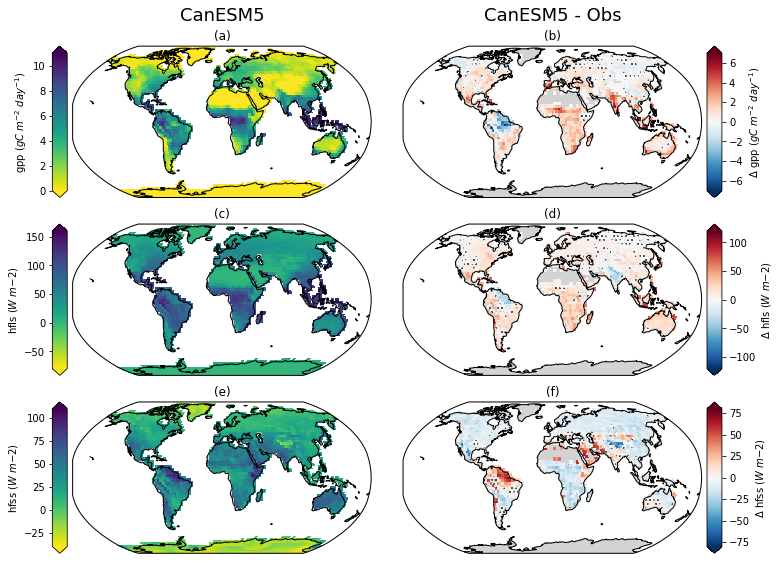

In [10]:
#Global time means - plotting

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson()))
fig.subplots_adjust(wspace=0.1, hspace=-0.4)
title_fontsize = 18

levels = [0,0.050,1.1]
hatches = [''] + (len(levels)-1)*['...']
plot_axes = (ax1,ax3,ax5, ax2,ax4,ax6)
plot_data = [gpp_mean_masked['gpp'],hfls_mean_masked['hfls'],hfss_mean_masked['hfss'],gpp_anomaly['gpp'],hfls_anomaly['hfls'],hfss_anomaly['hfss']]
cb_labels = [r'gpp ($gC$ $m^{-2}$ $day^{-1}$)',
             r'hfls ($W$ $m{-2}$)',
             r'hfss ($W$ $m{-2}$)',
             r'$\Delta$ gpp ($gC$ $m^{-2}$ $day^{-1}$)',
             r'$\Delta$ hfls ($W$ $m{-2}$)',
             r'$\Delta$ hfss ($W$ $m{-2}$)']
plot_labels = ['(a)','(c)','(e)','(b)','(d)','(f)',]
limits = [(0,11),(-80,160),(-40,110),(-7,7),(-120,120),(-80,80)]
ttests = [None, None, None, ttest_gpp, ttest_hfls, ttest_hfss]

for ax, data, cb_label, plot_label,limit,ttest in zip(plot_axes,plot_data,cb_labels,plot_labels,limits,ttests):
    cb_loc = 'left'
    cmap = plt.cm.viridis_r
    if ax in [ax2,ax4,ax6]:
        cb_loc = 'right'
        cmap = plt.cm.RdBu_r
        ax.contourf(ttest.lon, ttest.lat, ttest, alpha=0, levels = levels, hatches = hatches, transform=ccrs.PlateCarree(),zorder=100)
    cb_data = ax.pcolormesh(data.lon, data.lat, data, cmap=cmap, vmin=limit[0], vmax=limit[1], transform=ccrs.PlateCarree(), rasterized=True)
    pltm.add_cbar(cb_loc, fig, ax, cb_data, extend='both', label = cb_label)    
    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.set_title(plot_label)
    if ax == ax1:
        ax.text(0.5, 1.2, 'CanESM5', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize, transform=ax.transAxes)
    if ax == ax2:
        ax.text(0.5, 1.2, 'CanESM5 - Obs', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize, transform=ax.transAxes)


fig.savefig('plots/fig-12_land_surface_timemeans.png', bbox_inches='tight')
fig.savefig('plots/fig-12_land_surface_timemeans.pdf', bbox_inches='tight')

In [11]:
#open CanESM2 data for stats on global timemeans 
gpp_CanESM2 = xr.open_dataset('input_data/processed_data/remap-woa09_masked_gpp_Lmon_CanESM2_historical-r1_r1i1p1_1982-01-01-2009-01-01.nc')['gpp'].sel(time=slice(start,end))*g_per_kg*seconds_per_day #units kg /m2 /s  -> g /m2 /day
gpp_mean_CanESM2 = pltm.get_weighted_globalmean(gpp_CanESM2, 'noleap', start, end)
gpp_mean_CanESM2.name = 'gpp'
gpp_sftlf_merged_CanESM2 = xr.merge([gpp_mean_CanESM2,sftlf])
gpp_mean_masked_CanESM2 = gpp_sftlf_merged_CanESM2.where(gpp_sftlf_merged_CanESM2.sftlf >land_threshold)
gpp_mean_masked_CanESM2 = pltm.addCyclicPoint(gpp_mean_masked_CanESM2,'lon')


hfls_CanESM2 = xr.open_dataset('input_data/processed_data/remap-woa09_masked_hfls_Amon_CanESM2_historical-r1_r1i1p1_1982-01-01-2009-01-01.nc')['hfls'].sel(time=slice(start,end))
hfls_mean_CanESM2 = pltm.get_weighted_globalmean(hfls_CanESM2, 'noleap', start, end)
hfls_mean_CanESM2.name = 'hfls'
hfls_sftlf_merged_CanESM2 = xr.merge([hfls_mean_CanESM2,sftlf])
hfls_mean_masked_CanESM2 = hfls_sftlf_merged_CanESM2.where(hfls_sftlf_merged_CanESM2.sftlf >land_threshold)
hfls_mean_masked_CanESM2 = pltm.addCyclicPoint(hfls_mean_masked_CanESM2,'lon')


hfss_CanESM2 = xr.open_dataset('input_data/processed_data/remap-woa09_masked_hfss_Amon_CanESM2_historical-r1_r1i1p1_1982-01-01-2009-01-01.nc')['hfss'].sel(time=slice(start,end))
hfss_mean_CanESM2 = pltm.get_weighted_globalmean(hfss_CanESM2, 'noleap', start, end)
hfss_mean_CanESM2.name = 'hfss'
hfss_sftlf_merged_CanESM2 = xr.merge([hfss_mean_CanESM2,sftlf])
hfss_mean_masked_CanESM2 = hfss_sftlf_merged_CanESM2.where(hfss_sftlf_merged_CanESM2.sftlf >land_threshold)
hfss_mean_masked_CanESM2 = pltm.addCyclicPoint(hfss_mean_masked_CanESM2,'lon')

gpp_anomaly_CanESM2  = gpp_mean_masked_CanESM2 - gpp_obs_mean
hfls_anomaly_CanESM2 = hfls_mean_masked_CanESM2 - hfls_obs_mean
hfss_anomaly_CanESM2 = hfss_mean_masked_CanESM2 - hfss_obs_mean

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


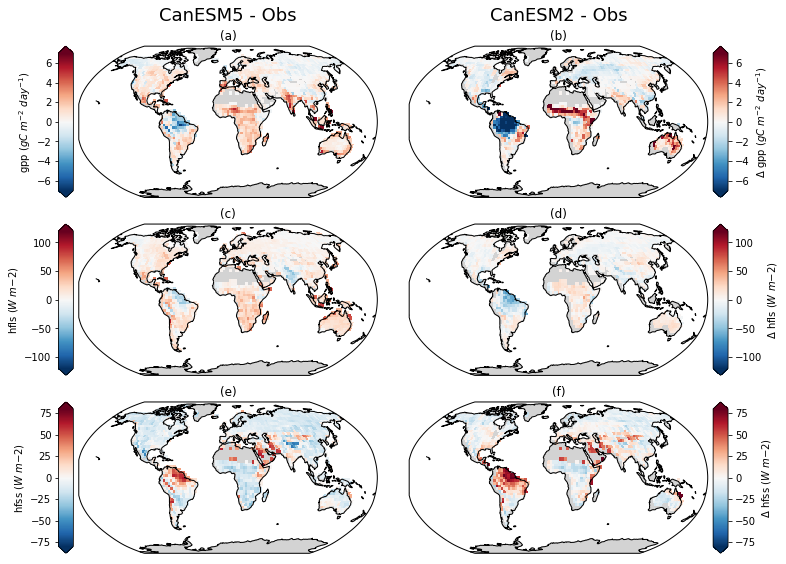

In [12]:
#test plot for CanESM5 and CanESM2 anomalies

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson()))
fig.subplots_adjust(wspace=0.1, hspace=-0.4)
title_fontsize = 18

levels = [0,0.050,1.1]
hatches = [''] + (len(levels)-1)*['...']
plot_axes = (ax1,ax3,ax5, ax2,ax4,ax6)
#plot_data = [gpp_mean_masked['gpp'],hfls_mean_masked['hfls'],hfss_mean_masked['hfss'],gpp_mean_masked_CanESM2['gpp'],hfls_mean_masked_CanESM2['hfls'],hfss_mean_masked_CanESM2['hfss']]
plot_data = [gpp_anomaly['gpp'],hfls_anomaly['hfls'],hfss_anomaly['hfss'],gpp_anomaly_CanESM2['gpp'],hfls_anomaly_CanESM2['hfls'],hfss_anomaly_CanESM2['hfss']]

cb_labels = [r'gpp ($gC$ $m^{-2}$ $day^{-1}$)',
             r'hfls ($W$ $m{-2}$)',
             r'hfss ($W$ $m{-2}$)',
             r'$\Delta$ gpp ($gC$ $m^{-2}$ $day^{-1}$)',
             r'$\Delta$ hfls ($W$ $m{-2}$)',
             r'$\Delta$ hfss ($W$ $m{-2}$)']
plot_labels = ['(a)','(c)','(e)','(b)','(d)','(f)',]
#limits = [(0,11),(-80,160),(-40,110),(0,11),(-80,160),(-40,110)]
limits = [(-7,7),(-120,120),(-80,80),(-7,7),(-120,120),(-80,80)]

for ax, data, cb_label, plot_label,limit in zip(plot_axes,plot_data,cb_labels,plot_labels,limits):
    cb_loc = 'left'
    cmap = plt.cm.RdBu_r
    if ax in [ax2,ax4,ax6]:
        cb_loc = 'right'
    cb_data = ax.pcolormesh(data.lon, data.lat, data, cmap=cmap, vmin=limit[0], vmax=limit[1], transform=ccrs.PlateCarree())
    pltm.add_cbar(cb_loc, fig, ax, cb_data, extend='both', label = cb_label)    
    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.set_title(plot_label)
    if ax == ax1:
        ax.text(0.5, 1.2, 'CanESM5 - Obs', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize, transform=ax.transAxes)
    if ax == ax2:
        ax.text(0.5, 1.2, 'CanESM2 - Obs', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize, transform=ax.transAxes)


In [13]:
##### statistics - for global time means
xyzt ='TTFF'
av_dims = ['time']
weight = pltm.addCyclicPoint(xr.open_dataset('input_data/obs/gpp_GBAF_128x64_gridarea.nc')['cell_area'], 'lon')
calc_skill_score=True


#the following lists will be zipped for the stats calcs, so all info should be entered accordingly
model_names        = ['CanESM5','CanESM5','CanESM5',
                      'CanESM2','CanESM2','CanESM2']
model_datasets     = [gpp_mean_masked['gpp'],hfls_mean_masked['hfls'],hfss_mean_masked['hfss'],
                      gpp_mean_masked_CanESM2['gpp'],hfls_mean_masked_CanESM2['hfls'],hfss_mean_masked_CanESM2['hfss']]
model_fulldatasets = [pltm.addCyclicPoint(gpp,'lon'),pltm.addCyclicPoint(hfls,'lon'),pltm.addCyclicPoint(hfss,'lon'),
                      pltm.addCyclicPoint(gpp_CanESM2,'lon'),pltm.addCyclicPoint(hfls_CanESM2,'lon'),pltm.addCyclicPoint(hfss_CanESM2,'lon')]

obs_names        = ['GBAF','GBAF','GBAF',
                   'GBAF','GBAF','GBAF']
obs_datasets     = [gpp_obs_mean,hfls_obs_mean,hfss_obs_mean,
                   gpp_obs_mean,hfls_obs_mean,hfss_obs_mean]
obs_fulldatasets = [pltm.addCyclicPoint(gpp_obs,'lon'),pltm.addCyclicPoint(hfls_obs,'lon'),pltm.addCyclicPoint(hfss_obs,'lon'),
                   pltm.addCyclicPoint(gpp_obs,'lon'),pltm.addCyclicPoint(hfls_obs,'lon'),pltm.addCyclicPoint(hfss_obs,'lon')]

stats_names = ['gpp_global_timemean','hfls_global_timemean','hfss_global_timemean',
              'gpp_global_timemean_CanESM2','hfls_global_timemean_CanESM2','hfss_global_timemean_CanESM2',]
varslist    = ['gpp','hfls','hfss',
              'gpp','hfls','hfss']    


bst.calc_stats_and_write(obs_datasets, obs_fulldatasets, obs_names, model_datasets, model_fulldatasets, model_names, stats_names, varslist, weight, xyzt, av_dims, start, end, calc_skill_score=calc_skill_score)

gpp CanESM5 GBAF


/fs/site2/dev/eccc/crd/ccrn/users/scrd104/cmip6_gmd_figures/modules/basic_stats.py:330: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = dataset.indexes['time'].to_datetimeindex() #set all datetime types to datetime64 for S_rmse calc
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/fs/site2/dev/eccc/crd/ccrn/users/scrd104/cmip6_gmd_figures/modules/basic_stats.py:269: RuntimeWarning: divide by zero encountered in true_divide
  e_bias = np.abs(bias)/std_flat[combined_in

{'bias': 0.5979421706223917, 'RMSE': 1.5581572809751527, 'CRMSE': 1.438860407700227, 'corrcoeff': 0.8298204380046016, 'model_std': 2.531161129532629, 'obs_std': 2.374747664617973, 'S_bias': 0.515504693047352, 'S_rmse': 0.3781296230795152, 'S_dist': 0.9111977287064942}
hfls CanESM5 GBAF
{'bias': 10.591319063570742, 'RMSE': 20.554415436676003, 'CRMSE': 17.615560009182445, 'corrcoeff': 0.8455270111327018, 'model_std': 32.99210094101668, 'obs_std': 27.89812036031793, 'S_bias': 0.5522747363742357, 'S_rmse': 0.38570252399957344, 'S_dist': 0.8972886331377197}
hfss CanESM5 GBAF
{'bias': -3.7247457936758055, 'RMSE': 18.20290546591478, 'CRMSE': 17.81774498003394, 'corrcoeff': 0.5814563172459299, 'model_std': 20.74595865762369, 'obs_std': 17.7716371741354, 'S_bias': 0.5459152446453763, 'S_rmse': 0.4279082577429792, 'S_dist': 0.7720909554017211}
gpp CanESM2 GBAF
{'bias': 0.17203668330967273, 'RMSE': 2.837808178774589, 'CRMSE': 2.832588681597764, 'corrcoeff': 0.3625598250928471, 'model_std': 2.6657

In [14]:
###Zonal means

#calculate interquartile ranges

gpp_sftlf_merged = xr.merge([gpp,sftlf])
gpp_masked = gpp_sftlf_merged.where(gpp_sftlf_merged.sftlf >land_threshold)
gpp_zms = gpp_masked['gpp'].mean(dim='lon')
gpp_25p = gpp_zms.quantile(0.25, dim='time')
gpp_75p = gpp_zms.quantile(0.75, dim='time')
gpp_obs_zms = gpp_obs.sel(time=slice(start,end)).mean(dim='lon')
gpp_obs_25p = gpp_obs_zms.quantile(0.25, dim='time')
gpp_obs_75p = gpp_obs_zms.quantile(0.75, dim='time')

hfls_sftlf_merged = xr.merge([hfls,sftlf])
hfls_masked = hfls_sftlf_merged.where(hfls_sftlf_merged.sftlf >land_threshold)
hfls_zms = hfls_masked['hfls'].mean(dim='lon')
hfls_25p = hfls_zms.quantile(0.25, dim='time')
hfls_75p = hfls_zms.quantile(0.75, dim='time')
hfls_obs_zms = hfls_obs.mean(dim='lon')
hfls_obs_25p = hfls_obs_zms.quantile(0.25, dim='time')
hfls_obs_75p = hfls_obs_zms.quantile(0.75, dim='time')

hfss_sftlf_merged = xr.merge([hfss,sftlf])
hfss_masked = hfss_sftlf_merged.where(hfss_sftlf_merged.sftlf >land_threshold)
hfss_zms = hfss_masked['hfss'].mean(dim='lon')
hfss_25p = hfss_zms.quantile(0.25, dim='time')
hfss_75p = hfss_zms.quantile(0.75, dim='time')
hfss_obs_zms = hfss_obs.mean(dim='lon')
hfss_obs_25p = hfss_obs_zms.quantile(0.25, dim='time')
hfss_obs_75p = hfss_obs_zms.quantile(0.75, dim='time')

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


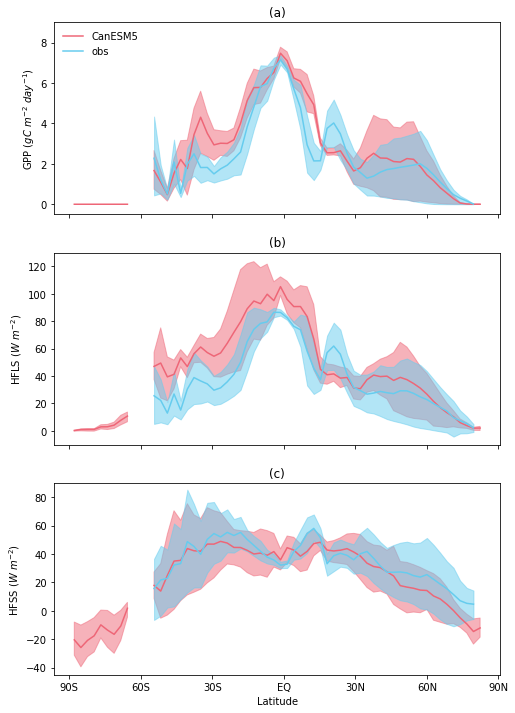

In [15]:
#plotting - zonal means

fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(8,12))
fig.subplots_adjust(wspace=0.4, hspace=0.2)
title_fontsize = 18


# Zonal means
ax1.plot(gpp_mean_masked.lat, gpp_mean_masked['gpp'].mean(dim='lon'), color=color_dict['CanESM5'],label='CanESM5')
ax1.plot(gpp_obs_mean.lat, gpp_obs_mean.mean(dim='lon'), color=color_dict['GBAF'],label='obs')
ax1.fill_between(gpp_25p.lat, gpp_25p, gpp_75p, color=color_dict['CanESM5'], alpha=0.5, zorder=0)
ax1.fill_between(gpp_obs_25p.lat, gpp_obs_25p, gpp_obs_75p, color=color_dict['GBAF'], alpha=0.5, zorder=0)
ax1.set_ylim([-0.5,9])
ax1.set_ylabel(r'GPP ($gC$ $m^{-2}$ $day^{-1}$)')
ax1.legend(loc='upper left',frameon=False)
ax1.set_title('(a)')

ax2.plot(hfls_mean_masked.lat, hfls_mean_masked['hfls'].mean(dim='lon'), label='hfls', color=color_dict['CanESM5'])
ax2.plot(hfls_obs_mean.lat, hfls_obs_mean.mean(dim='lon'), label='obs.', color=color_dict['GBAF'])
ax2.fill_between(hfls_25p.lat, hfls_25p, hfls_75p, color=color_dict['CanESM5'], alpha=0.5, zorder=0)
ax2.fill_between(hfls_obs_25p.lat, hfls_obs_25p, hfls_obs_75p, color=color_dict['GBAF'], alpha=0.5, zorder=0)
ax2.set_ylim([-10,130])
ax2.set_ylabel(r'HFLS ($W$ $m^{-2}$)')
ax2.set_title('(b)')

ax3.plot(hfss_mean_masked.lat, hfss_mean_masked['hfss'].mean(dim='lon'), label='hfss', color=color_dict['CanESM5'])
ax3.plot(hfss_obs_mean.lat, hfss_obs_mean.mean(dim='lon'), label='obs.', color=color_dict['GBAF'])
ax3.fill_between(hfss_25p.lat, hfss_25p, hfss_75p, color=color_dict['CanESM5'], alpha=0.5, zorder=0)
ax3.fill_between(hfss_obs_25p.lat, hfss_obs_25p, hfss_obs_75p, color=color_dict['GBAF'], alpha=0.5, zorder=0)
ax3.set_ylim([-45,90])
ax3.set_ylabel(r'HFSS ($W$ $m^{-2}$)')
ax3.set_title('(c)')

for ax in [ax1,ax2,ax3]:
    ax.set_xticks(np.arange(-90,91,30)) 
    ax.set_xticklabels([])
    if ax == ax3:
        ax.set_xticklabels(('90S','60S','30S','EQ','30N','60N','90N'))
        ax.set_xlabel('Latitude')



fig.savefig('plots/fig-13_land_surface_zonal_means.png', bbox_inches='tight')
fig.savefig('plots/fig-13_land_surface_zonal_means.pdf', bbox_inches='tight')

In [16]:
##### statistics - for 1D zonal means
xyzt = 'FTFF'
av_dims = ['time','lon']
weight = None
calc_skill_score=True

#the following lists will be zipped for the stats calcs, so all info should be entered accordingly
model_names    = ['CanESM5','CanESM5','CanESM5']
model_datasets    = [gpp_mean_masked['gpp'].mean(dim='lon'),hfls_mean_masked['hfls'].mean(dim='lon'),hfss_mean_masked['hfss'].mean(dim='lon')]
model_fulldatasets = [gpp_masked['gpp'].sel(time=slice(start, end)), hfls_masked['hfls'].sel(time=slice(start, end)), hfss_masked['hfss'].sel(time=slice(start, end))]

obs_names    = ['GBAF','GBAF','GBAF']
obs_datasets    = [gpp_obs_mean.mean(dim='lon'),hfls_obs_mean.mean(dim='lon'),hfss_obs_mean.mean(dim='lon')]
obs_fulldatasets = [gpp_obs.sel(time=slice(start, end)), hfls_obs.sel(time=slice(start, end)), hfss_obs.sel(time=slice(start, end))]

stats_names = ['gpp_zonal_timemean','hfls_zonal_timemean','hfss_zonal_timemean',]
varslist    = ['gpp','hfls','hfss']    


bst.calc_stats_and_write(obs_datasets, obs_fulldatasets, obs_names, model_datasets, model_fulldatasets, model_names, stats_names, varslist, weight, xyzt, av_dims, start, end, calc_skill_score=calc_skill_score)

gpp CanESM5 GBAF
{'bias': 0.43686625872841367, 'RMSE': 1.0065273965158574, 'CRMSE': 0.9067774103503178, 'corrcoeff': 0.8875772408414705, 'model_std': 1.9668613666388375, 'obs_std': 1.7819990649893234, 'S_bias': 0.7144970116484629, 'S_rmse': 0.42334324049847233, 'S_dist': 0.9346533087444903}
hfls CanESM5 GBAF
{'bias': 11.981999684613772, 'RMSE': 17.436491925954083, 'CRMSE': 12.667396506061433, 'corrcoeff': 0.8860121065056206, 'model_std': 27.166098781962052, 'obs_std': 22.72544034074196, 'S_bias': 0.6017855346379686, 'S_rmse': 0.37577071995526, 'S_dist': 0.9135915537443879}
hfss CanESM5 GBAF
{'bias': -4.134910180229269, 'RMSE': 7.8609825392337305, 'CRMSE': 6.68562370191248, 'corrcoeff': 0.9187815623187184, 'model_std': 16.595942833139574, 'obs_std': 13.915694508966942, 'S_bias': 0.7552006095824676, 'S_rmse': 0.38217848714855723, 'S_dist': 0.9302300873941834}


In [17]:
### Functional responses
bins_tas = np.arange(-31.25,42.5,2.5)
labels_tas = bins_tas[:-1]+1.25

bins_pr = np.arange(-0.5,12.5,1)
labels_pr = bins_pr[:-1]+0.5

gpp = xr.open_dataset(CanESM5_dir + 'Lmon/gpp/gn/v20190429/gpp_Lmon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc')['gpp']*g_per_kg*seconds_per_day
gpp_obs = xr.open_dataset('input_data/obs/gpp_GBAF_128x64.nc')['gpp']*g_per_kg*seconds_per_day
gpp_mean = pltm.get_weighted_globalmean(gpp, 'noleap', start, end)
gpp_mean['lat'] = gpp_mean['lat'].round(4)
gpp_obs_mean = pltm.get_weighted_globalmean(gpp_obs, 'standard', start, end) 
gpp_obs_mean['lat'] = gpp_obs_mean['lat'].round(4)
gpp_mean.name = 'gpp'
gpp_obs_mean.name = 'gpp_obs'

tas = xr.open_dataset(CanESM5_dir + 'Amon/tas/gn/v20190429/tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc')['tas'] - zeroC_in_K 
tas_obs = xr.open_dataset('input_data/obs/tas_monthly.nc')['tas'] # in C
tas_mean = pltm.get_weighted_globalmean(tas, 'noleap', start, end)
tas_mean['lat'] = tas_mean['lat'].round(4)
tas_obs_mean = pltm.get_weighted_globalmean(tas_obs, 'standard', start, end)
tas_obs_mean['lat'] = tas_obs_mean['lat'].round(4)
tas_mean.name = 'tas'
tas_obs_mean.name = 'tas_obs'

pr = xr.open_dataset(CanESM5_dir + 'Amon/pr/gn/v20190429/pr_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc')['pr']*seconds_per_day #convert to mm/day 
pr_obs = xr.open_dataset('input_data/obs/pr_monthly.nc')['pr']*seconds_per_day #convert to mm/day 
pr_mean = pltm.get_weighted_globalmean(pr, 'noleap', start, end)
pr_mean['lat'] = pr_mean['lat'].round(4)
pr_obs_mean = pltm.get_weighted_globalmean(pr_obs, 'standard', start, end)
pr_obs_mean['lat'] = pr_obs_mean['lat'].round(4)
pr_mean.name = 'pr'
pr_obs_mean.name = 'pr_obs'

sftlf['lat'] = sftlf['lat'].round(4)

merged = xr.merge([gpp_mean, gpp_obs_mean, tas_mean, tas_obs_mean, pr_mean, pr_obs_mean, sftlf])
masked = merged.where(merged.sftlf > land_threshold)
masked = masked.drop('sftlf')
masked = masked.where(~np.isnan(masked.gpp)) 
masked = masked.where(~np.isnan(masked.gpp_obs)) 

binned_tas = masked.groupby_bins('tas', bins_tas, right=True, labels=labels_tas)
binned_tas_mean = binned_tas.mean()
binned_tas_std  = binned_tas.std()
binned_tas_count = binned_tas.count()

binned_tas_obs = masked.groupby_bins('tas_obs', bins_tas, right=True, labels=labels_tas)
binned_tas_obs_mean = binned_tas_obs.mean()
binned_tas_obs_std  = binned_tas_obs.std()
binned_tas_obs_count = binned_tas_obs.count()

binned_pr = masked.groupby_bins('pr', bins_pr, right=True, labels=labels_pr)
binned_pr_mean = binned_pr.mean()
binned_pr_std  = binned_pr.std()
binned_pr_count = binned_pr.count()

binned_pr_obs = masked.groupby_bins('pr_obs', bins_pr, right=True, labels=labels_pr)
binned_pr_obs_mean = binned_pr_obs.mean()
binned_pr_obs_std  = binned_pr_obs.std()
binned_pr_obs_count = binned_pr_obs.count()

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/groupby.py:758: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/groupby.py:758: FutureWarning: Default reduction dimension will be changed to the grouped

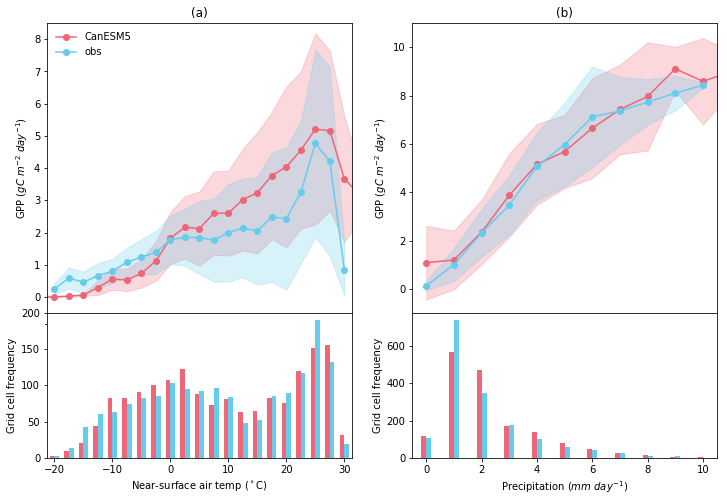

In [18]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,8),gridspec_kw={'height_ratios': [2, 1]})

fig.subplots_adjust(wspace=0.2, hspace=0.)
title_fontsize = 18

ax1.plot(binned_tas_mean['tas_bins'], binned_tas_mean.gpp, marker='o', color=color_dict['CanESM5'],label = 'CanESM5')
ax1.fill_between(binned_tas_std['tas_bins'], binned_tas_mean.gpp + binned_tas_std.gpp, binned_tas_mean.gpp - binned_tas_std.gpp, color=color_dict['CanESM5'], alpha=0.25, zorder=0)
ax1.plot(binned_tas_obs_mean['tas_obs_bins'],binned_tas_obs_mean.gpp_obs, marker='o',color=color_dict['GBAF'],label = 'obs')
ax1.fill_between(binned_tas_obs_std['tas_obs_bins'], binned_tas_obs_mean.gpp_obs + binned_tas_obs_std.gpp_obs, binned_tas_obs_mean.gpp_obs - binned_tas_obs_std.gpp_obs, color=color_dict['GBAF'], alpha=0.25, zorder=0)
ax1.set_ylim(-0.5,8.5)
ax1.set_xlim(-21.25,31.25)
ax1.legend(loc='upper left',frameon=False)
ax1.set_ylabel(r'GPP ($gC$ $m^{-2}$ $day^{-1}$)')
ax1.set_title('(a)')

ax2.plot(binned_pr_mean['pr_bins'], binned_pr_mean.gpp, marker='o', color=color_dict['CanESM5'])
ax2.fill_between(binned_pr_std['pr_bins'], binned_pr_mean.gpp + binned_pr_std.gpp, binned_pr_mean.gpp - binned_pr_std.gpp, color=color_dict['CanESM5'], alpha=0.25, zorder=0)
ax2.plot(binned_pr_obs_mean['pr_obs_bins'], binned_pr_obs_mean.gpp_obs, marker='o',color=color_dict['GBAF'])
ax2.fill_between(binned_pr_obs_std['pr_obs_bins'], binned_pr_obs_mean.gpp_obs + binned_pr_obs_std.gpp_obs, binned_pr_obs_mean.gpp_obs - binned_pr_obs_std.gpp_obs, color=color_dict['GBAF'], alpha=0.25, zorder=0)
ax2.set_ylim(-1,11)
ax2.set_xlim(-0.5,10.5)
ax2.set_ylabel(r'GPP ($gC$ $m^{-2}$ $day^{-1}$)')
ax2.set_title('(b)')

ax3.bar(labels_tas, binned_tas_count['tas'].values, width=-0.8, align='edge', color=color_dict['CanESM5'])
ax3.bar(labels_tas, binned_tas_obs_count['tas_obs'].values, width=0.8, align='edge', color=color_dict['GBAF'])
ax3.set_xlim(-21.25,31.25)
ax3.set_ylabel('Grid cell frequency')
ax3.set_xlabel(r'Near-surface air temp ($^\circ$C)')

ax4.bar(labels_pr, binned_pr_count['pr'].values, width=-0.18, align='edge', color=color_dict['CanESM5'])
ax4.bar(labels_pr, binned_pr_obs_count['pr_obs'].values, width=0.18, align='edge', color=color_dict['GBAF'])
ax4.set_xlim(-0.5,10.5)
ax4.set_ylabel('Grid cell frequency')
ax4.set_xlabel(r'Precipitation ($mm$ $day^{-1}$)')

fig.savefig('plots/fig-14_land_surface_functional_response.png', bbox_inches='tight')
fig.savefig('plots/fig-14_land_surface_functional_response.pdf', bbox_inches='tight')